# Classification Models for Credit Card Fraud Detection on an Imbalanced Dataset
### University of Maryland, Baltimore County (UMBC): DATA601 - Intro to Data Science Project  
#### Matthew Han - mhan4@umbc.edu, Abhinaya Mudunuri - hu03574@umbc.edu, Suhani Kalpeshkumar Shah - suhanis1@umbc.edu

We import necessary libraries and define the class Transaction, which holds all the predictive features for each row/instance in creditcard.csv.
Also initialize all_transactions which holds all instances of Transaction loaded from creditcard.csv

In [ ]:
#%pip install csv
#%pip install numpy
#%pip install pandas
#%pip install imblearn
#%pip install matplotlib
#%pip install sklearn
#%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [157]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn
import sklearn

all_transactions = [] #List of all transactions from the .csv file

class Transaction:
    def __init__(self, row):
        self.Time = row[0]
        self.V = row[1:29] 
        self.Amount = row[29]
        self.Class = row[30]
        self.Features = row[:30] #All features except class, for use in testing/training

Open creditcard.csv and cast each row to an new instance of Transaction, then append each new instance to all_transactions.

In [158]:
f = open('./creditcard.csv',newline='') #Open the csv file
reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC) #quoting=csv.QUOTE_NONNUMERIC places quotes around any values that are not integers/floats/numeric

print("Features:", next(reader))

next(reader) #Iterate to next row to skip the first row that is just the labels for each column
for row in reader: # A list of rows
    NewTransaction = Transaction(row) #Create new Transaction instance, and load the data from the csv file
    all_transactions.append(NewTransaction) #Append the instance to the total list of all transactions

f.close() #Close file after loading is finished

Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


Bar graph visualization of the dataset class distribution

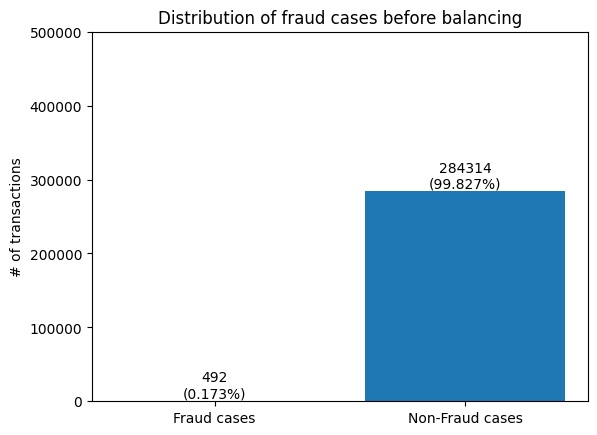

In [159]:
#Extract class values from the data
class_distribution = []
for each in all_transactions:
    class_distribution.append(each.Class)

#Count cases where class=1 and class=0
count_fraud = 0
count_not_fraud = 0
for each in class_distribution:
    if each == '0':
        count_not_fraud += 1
    elif each == '1':
        count_fraud += 1

#Define labels and values for the bar graph
label = ['Fraud cases','Non-Fraud cases']
values = [count_fraud, count_not_fraud]

#Plot the bargraph, set ylimit to 500k and add text to each bar, which lists the total count and percentage representation of each class
fig, ax = plt.subplots()
ax.set_title('Distribution of fraud cases before balancing')
ax.bar(label, values)
ax.set_ylabel('# of transactions')
ax.set_ylim(0, 500000)
for i in range(len(values)):
    ax.text(i, values[i], str(values[i])+'\n'+'('+str(round(values[i]/len(class_distribution)*100,3))+'%'+')', ha='center', va='bottom')


We now shift to the training phase for the classification models. Due to the dataset being extremely unbalanced we apply the Synthetic Minority Oversampling Technique (SMOTE) to oversample (generate) fake cases of the minority class: where Class=1(fraud=true).

In [160]:
percent80 = int(len(all_transactions) * 0.8) #Index of the dataset at the 80% cutoff
training_data = all_transactions[:percent80] #separate training data as 80% of the original dataset
test_data = all_transactions[percent80:] #seperate test data as the remaining 20%

#print(len(training_data) / len(all_transactions))
#print(len(test_data) / len(all_transactions))
#print(len(all_transactions))

features = [] #extract features/attributes from the training dataset to use in oversampling
classes = [] #extract classes

for each in training_data:
    features.append(each.Features)
    classes.append(int(each.Class))
print("Number of non-fraud cases in training data:", classes.count(0))
print("Number of fraud cases in training data:", classes.count(1))

x_train = np.array(features) #Convert to ndarray
y_train = np.array(classes) #Convery to ndarray

print("X Shape before SMOTE:", x_train.shape)
print("Y Shape before SMOTE:", y_train.shape)

oversample = imblearn.over_sampling.SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train) #Apply SMOTE

print("X Shape after SMOTE:", x_train.shape)
print("Y Shape after SMOTE:", y_train.shape)

Number of non-fraud cases in training data: 227427
Number of fraud cases in training data: 417
X Shape before SMOTE: (227844, 30)
Y Shape before SMOTE: (227844,)
X Shape after SMOTE: (454854, 30)
Y Shape after SMOTE: (454854,)


We can now visualize the distribution of fraud cases and non-fraud cases in the training data after SMOTE balancing, which should be an equal split

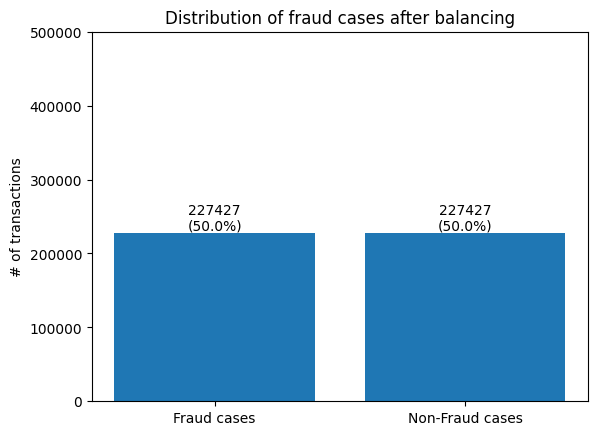

In [161]:
fraud_count = np.count_nonzero(y_train == 1)
n_fraud_count = np.count_nonzero(y_train == 0)
label = ['Fraud cases','Non-Fraud cases']
values = [fraud_count, n_fraud_count]

#Plot the bargraph, set ylimit to 500k and add text to each bar, which lists the total count and percentage representation of each class
fig, ax = plt.subplots()
ax.set_title('Distribution of fraud cases after balancing')
ax.bar(label, values)
ax.set_ylabel('# of transactions')
ax.set_ylim(0, 500000)
for i in range(len(values)):
    ax.text(i, values[i], str(values[i])+'\n'+'('+str(round(values[i]/len(y_train)*100,3))+'%'+')', ha='center', va='bottom')

Separate testing data to x and y

In [162]:
features = [] #extract features/attributes from test data
classes = [] #extract classes

for each in test_data:
    features.append(each.Features)
    classes.append(int(each.Class))
print("Number of non-fraud cases in test data:", classes.count(0))
print("Number of fraud cases in test data:", classes.count(1))

x_test = np.array(features)
y_test = np.array(classes)

Number of non-fraud cases in test data: 56887
Number of fraud cases in test data: 75


Implementation of Gradient Boosted Decision Tree classifier

In [ ]:
GBDT_model = sklearn.ensemble.HistGradientBoostingClassifier() 
GBDT_model.fit(x_train, y_train) 
y_predict = GBDT_model.predict(x_test) 
#y_predict_prob = GBDT_model.predict_proba(x_test) 


Bar graph visualization and confusion matrix of the GBDT model's results

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

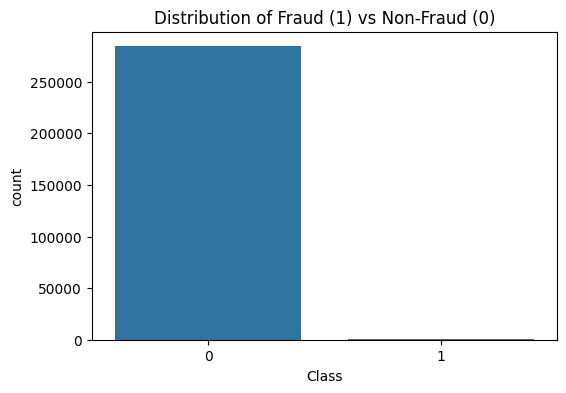

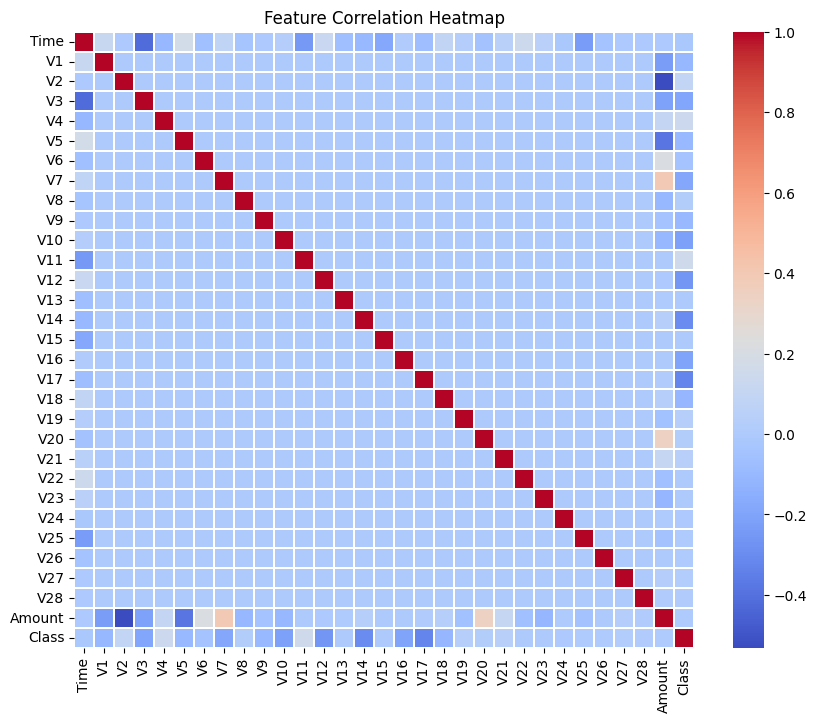

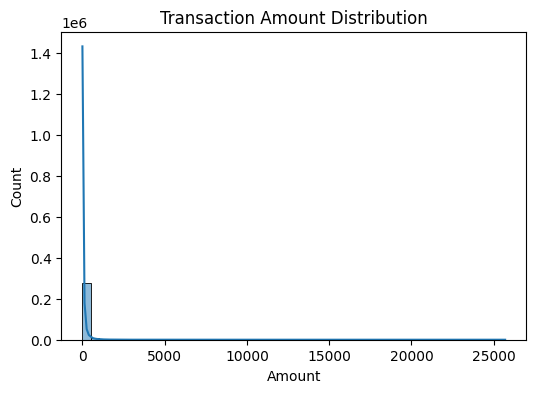

In [178]:
#Use y_predict for the bargraph: array of the GBDT model's predicted classifications (0 or 1). The bargraph should be like the graphs that showed the distribution of fraud caes or non-fraud cases in the
#previous cells. Optional: create another bargraph that compares the accuracy of the model's predictions to the actual results; by accessing y_test and y_pred and seeing if the predictions that
#classified a row as Class=1 in y_pred(predicted results) was actually a fraud case in y_test(actual results) 

#Use ConfusionMatrixDisplay from sklearn to generate a confusion matrix, and explain what it shows
sklearn.metrics.confusion_matrix(y_test, y_predict)

import seaborn as sns

df = pd.read_csv('creditcard.csv')

# Basic info
print(df.shape)
print(df.head())

# ------------------------------
# 1️⃣ Distribution of Fraud vs Non-Fraud
# ------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Fraud (1) vs Non-Fraud (0)')
plt.show()

# ------------------------------
# 2️⃣ Correlation Heatmap
# ------------------------------
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.2)
plt.title('Feature Correlation Heatmap')
plt.show()

# ------------------------------
# 3️⃣ Transaction Amount Distribution
# ------------------------------
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()



Implementation of logistic regression classifer

In [171]:
#Use LogisticRegression from sklearn.linear_model, and fit(x_train, y_train) to train the model. Then predict and cast to a variable like what was done in the GBDT model, which will be used for the bargraph
""""
from sklearn.preprocessing import StandardScaler
#Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
"""

# Train logistic regression model
model = sklearn.linear_model.LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
model.fit(x_train, y_train)

# Predict on test data
y_pred = model.predict(x_test)

# Evaluate model
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
prec = sklearn.metrics.precision_score(y_test, y_pred, zero_division=0)
rec = sklearn.metrics.recall_score(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred)

# Print results
print("Model Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

Model Evaluation Metrics:
Accuracy : 0.9988
Precision: 0.5221
Recall   : 0.7867
F1 Score : 0.6277


Bar graph visualization and confusion matrix of the logit model's results

In [173]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[56833,    54],
       [   16,    59]])